In [900]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scorecardpy as sc
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Data Importing

In [811]:
# import the credit data
# treat repayment status as continuous as it has many levels and is ordinal
data = pd.read_csv("data.csv")

data.columns = ['credit_line', 'gender', 'edu', 'marital', 'age',
                'repay_9', 'repay_8', 'repay_7', 'repay_6', 'repay_5', 'repay_4',
                'bill_9', 'bill_8', 'bill_7', 'bill_6', 'bill_5', 'bill_4',
                'pre_9', 'pre_8', 'pre_7', 'pre_6', 'pre_5', 'pre_4',
                'default']

for i in data.columns.delete(-1):
    if data[i].nunique() < 10:
        data[i] = data[i].astype('category')


In [812]:
data.head()

,credit_line,gender,edu,marital,age,repay_9,repay_8,repay_7,repay_6,repay_5,...,bill_6,bill_5,bill_4,pre_9,pre_8,pre_7,pre_6,pre_5,pre_4,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [813]:
data.dtypes

credit_line       int64
gender         category
edu            category
marital        category
age               int64
repay_9           int64
repay_8           int64
repay_7           int64
repay_6           int64
repay_5           int64
repay_4           int64
bill_9            int64
bill_8            int64
bill_7            int64
bill_6            int64
bill_5            int64
bill_4            int64
pre_9             int64
pre_8             int64
pre_7             int64
pre_6             int64
pre_5             int64
pre_4             int64
default           int64
dtype: object

In [814]:
data.describe()

,credit_line,age,repay_9,repay_8,repay_7,repay_6,repay_5,repay_4,bill_9,bill_8,...,bill_6,bill_5,bill_4,pre_9,pre_8,pre_7,pre_6,pre_5,pre_4,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [815]:
# education and marital status have more level than expected
data.describe(include = 'category').transpose()

,count,unique,top,freq
gender,30000,2,2,18112
edu,30000,7,2,14030
marital,30000,4,2,15964


In [816]:
# unbalanced data, use f1 score for metrics
data.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

#### Data Cleaning

In [817]:
# Change unknown values for edu and marital status to 'other' while keep others the same, as edu and 
# marital stutus are categorical and other are either continuous or ordinal.
data['edu'] = np.where(~data.edu.isin([1, 2, 3, 4]), 4,data.edu)
data['marital'] = np.where(~data.marital.isin([1, 2, 3]), 3, data.marital)

data['edu'] = data.edu.astype('category')
data['marital'] = data.marital.astype('category')

In [818]:
data.describe(include = 'category').transpose()

,count,unique,top,freq
gender,30000,2,2,18112
edu,30000,4,2,14030
marital,30000,3,2,15964


#### Exploratory Analysis

In [660]:
# information value to see predictive power
sc.iv(data, 'default')

,variable,info_value
21,repay_9,0.877161
15,repay_8,0.548882
1,repay_7,0.416046
18,repay_6,0.367266
8,pre_9,0.354998
0,pre_4,0.340639
10,repay_5,0.340341
16,pre_7,0.340153
12,pre_6,0.339778
3,pre_5,0.339478


[INFO] creating woe binning ...


{'repay_9': <Figure size 432x288 with 2 Axes>,
 'pre_9': <Figure size 432x288 with 2 Axes>,
 'bill_4': <Figure size 432x288 with 2 Axes>,
 'edu': <Figure size 432x288 with 2 Axes>,
 'gender': <Figure size 432x288 with 2 Axes>}

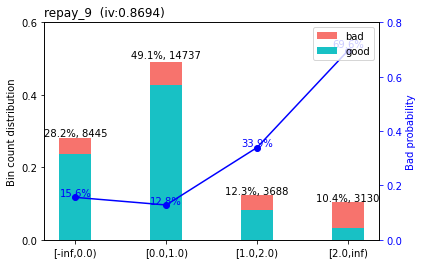

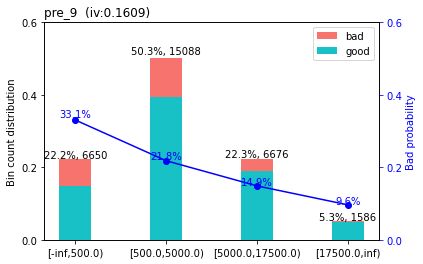

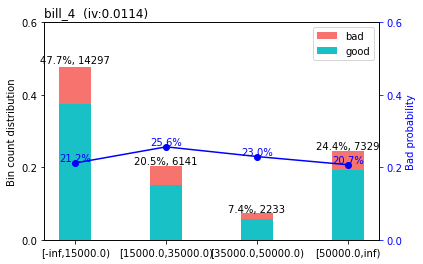

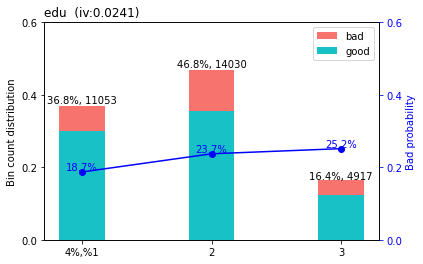

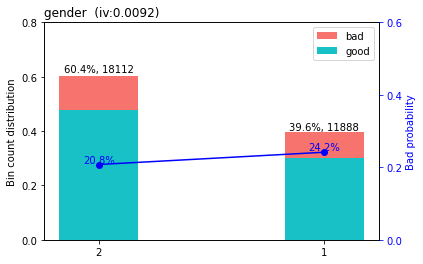

In [819]:
# The higher the repayment status, the higher the PD, especially for status >= 2
# The higher the previous payment, the lower the PD.
data_str = data.copy()
data_str['edu'] = data.edu.astype('string')
data_str['gender'] = data.gender.astype('string')

bins = sc.woebin(data_str, 'default', ['repay_9', 'pre_9', 'bill_4', 'edu', 'gender'])

sc.woebin_plot(bins)

In [820]:
# VIF test, high VIF for some attributes
x_0 = data.iloc[:, :-1]
vif = pd.DataFrame()
vif['feature'] = x_0.columns
vif['VIF'] = [variance_inflation_factor(x_0.values, i) for i in range(len(x_0.columns))]
vif

,feature,VIF
0,credit_line,4.045042
1,gender,9.138316
2,edu,7.404015
3,marital,6.353580
4,age,11.155951
5,repay_9,1.918283
6,repay_8,3.211462
7,repay_7,3.727665
8,repay_6,4.440211
9,repay_5,4.985794


#### Preprocessing

In [821]:
# Convert to categorical variable
encoder = OneHotEncoder(drop = 'first')
encoder.fit_transform(data[['gender', 'edu', 'marital']])
data[encoder.get_feature_names(['gender', 'edu', 'marital'])] = OneHotEncoder(drop = 'first').fit_transform(data[['gender', 'edu', 'marital']]).toarray()

In [822]:
# save the original copy of the data for tree-based models
data_tree = data.copy()

In [823]:
# Standardization for logistic regression
num_features = data.columns.drop(['default', 'gender', 'marital', 'edu', 
                                  'gender_2', 'edu_2', 'edu_3', 'edu_4', 'marital_2', 'marital_3'])
data[num_features] = StandardScaler().fit_transform(data[num_features])

#### Feature Engineering

In [824]:
# Use PCA to reduce repayment status, bill amount and previous payment amount
pca = PCA(n_components = 1)

In [825]:
features_1 = ['repay_9', 'repay_8', 'repay_7', 'repay_6', 'repay_5', 'repay_4']
features_2 = ['bill_9', 'bill_8', 'bill_7', 'bill_6', 'bill_5', 'bill_4']
features_3 = ['pre_9', 'pre_8', 'pre_7', 'pre_6', 'pre_5', 'pre_4']

In [826]:
data[['pca_repay']] = pca.fit_transform(data[features_1])
print(pca.components_)

data[['pca_bill']] = pca.fit_transform(data[features_2])
print(pca.components_)

data[['pca_pre']] = pca.fit_transform(data[features_3])
print(pca.components_)

[[0.35122879 0.40757891 0.42375919 0.43245618 0.42655565 0.40246472]]
[[0.40087622 0.41055536 0.41203506 0.41476148 0.41029126 0.40075388]]
[[0.45359053 0.44583748 0.44028862 0.39172153 0.34754647 0.35692604]]


In [827]:
data.head()

,credit_line,gender,edu,marital,age,repay_9,repay_8,repay_7,repay_6,repay_5,...,default,gender_2,edu_2,edu_3,edu_4,marital_2,marital_3,pca_repay,pca_bill,pca_pre
0,-1.136720,2,2,1,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,...,1,1.0,1.0,0.0,0.0,0.0,0.0,-0.477471,-1.611148,-0.721590
1,-0.365981,2,2,2,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,...,1,1.0,1.0,0.0,0.0,1.0,0.0,1.461637,-1.547595,-0.625405
2,-0.597202,2,2,2,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,0,1.0,1.0,0.0,0.0,1.0,0.0,0.393314,-1.035874,-0.491177
3,-0.905498,2,2,1,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,...,0,1.0,1.0,0.0,0.0,0.0,0.0,0.393314,-0.250712,-0.539174
4,-0.905498,1,2,1,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,...,0,0.0,1.0,0.0,0.0,0.0,0.0,-0.273290,-0.968951,0.534051


In [570]:
# information value to see predictive power
sc.iv(data, 'default')

,variable,info_value
2,pca_repay,1.140897
19,repay_9,0.877161
11,repay_8,0.548882
22,repay_7,0.416046
15,repay_6,0.367266
6,pre_9,0.354998
20,pre_4,0.340639
8,repay_5,0.340341
12,pre_7,0.340153
28,pre_6,0.339778


#### Feature Selection

In [828]:
x = data.drop(['gender', 'edu', 'marital', 'default', 'pca_repay', 'pca_bill', 'pca_pre'], axis = 1)
y = data.loc[:, 'default']

In [829]:
# forward selection, parsimonious.
ffs = SFS(LogisticRegression(C = 1e9, fit_intercept = False), 
          k_features = 'parsimonious',
          forward = True,
          scoring = 'f1',
          cv = 5).fit(sm.add_constant(x), y)

print(ffs.k_feature_names_)
print(ffs.k_score_)

('credit_line', 'age', 'repay_9', 'bill_9', 'edu_4')
0.44244322638988826


In [783]:
# backward selection, parsimonious.
sbs = SFS(LogisticRegression(C = 1e9, fit_intercept = False), 
          k_features = 'parsimonious',
          forward = False,
          scoring = 'f1',
          cv = 5).fit(sm.add_constant(x), y)

print(sbs.k_feature_names_)
print(sbs.k_score_)

('credit_line', 'age', 'repay_9', 'bill_9')
0.4405404794859443


In [784]:
# stepwise feature selection, parsimounious.
sffs = SFS(LogisticRegression(C = 1e9, fit_intercept = False), 
          k_features = 'parsimonious',
          forward = True,
          floating = True,
          scoring = 'f1',
          cv = 5).fit(sm.add_constant(x), y)

print(sffs.k_feature_names_)
print(sffs.k_score_)

('credit_line', 'age', 'repay_9', 'bill_9', 'edu_4')
0.44244322638988826


In [786]:
# Use PCA variables for feature selection
x = data.drop(['gender', 'edu', 'marital', 'default'] + features_1 + features_2 + features_3, axis = 1)
y = data.loc[:, 'default']

In [788]:
# forward selection, parsimonious.
ffs = SFS(LogisticRegression(C = 1e9, fit_intercept = False), 
          k_features = 'parsimonious',
          forward = True,
          scoring = 'f1',
          cv = 5).fit(sm.add_constant(x), y)

print(ffs.k_feature_names_)
print(ffs.k_score_)

('credit_line', 'age', 'pca_repay', 'pca_bill')
0.41389816231290555


In [789]:
# backward selection, parsimonious.
sbs = SFS(LogisticRegression(C = 1e9, fit_intercept = False), 
          k_features = 'parsimonious',
          forward = False,
          scoring = 'f1',
          cv = 5).fit(sm.add_constant(x), y)

print(sbs.k_feature_names_)
print(sbs.k_score_)

('credit_line', 'age', 'pca_repay', 'pca_bill')
0.41389816231290555


In [790]:
# stepwise feature selection, parsimonious.
sffs = SFS(LogisticRegression(C = 1e9, fit_intercept = False), 
          k_features = 'parsimonious',
          forward = True,
          floating = True,
          scoring = 'f1',
          cv = 5).fit(sm.add_constant(x), y)

print(sffs.k_feature_names_)
print(sffs.k_score_)

('credit_line', 'age', 'pca_repay', 'pca_bill')
0.41389816231290555


In [792]:
# forward selection, best.
ffs = SFS(LogisticRegression(C = 1e9, fit_intercept = False), 
          k_features = 'best',
          forward = True,
          scoring = 'f1',
          cv = 5).fit(sm.add_constant(x), y)

print(ffs.k_feature_names_)
print(ffs.k_score_)

('credit_line', 'age', 'edu_4', 'pca_repay', 'pca_bill')
0.4157456088544258


#### Logistic Regression Modeling

In [830]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 1)

In [831]:
model_1 = smf.logit(formula = 'default ~ credit_line + age + repay_9 + bill_9 + edu_4', data = data).fit()

Optimization terminated successfully.
         Current function value: 0.469854
         Iterations 7


In [832]:
print(model_1.summary())

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                30000
Model:                          Logit   Df Residuals:                    29994
Method:                           MLE   Df Model:                            5
Date:                Sat, 10 Jul 2021   Pseudo R-squ.:                  0.1108
Time:                        21:50:12   Log-Likelihood:                -14096.
converged:                       True   LL-Null:                       -15853.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.4185      0.016    -88.806      0.000      -1.450      -1.387
credit_line    -0.1993      0.018    -11.061      0.000      -0.235      -0.164
age             0.0897      0.015      6.182    

In [847]:
x = data[['credit_line', 'age', 'repay_9', 'bill_9', 'edu_4']]
y = data.loc[:, 'default']

model_1_cv = LogisticRegression(C = 1e9, fit_intercept = False)

scores_1 = cross_val_score(model_1_cv, sm.add_constant(x), y, scoring = 'f1', cv = folds)

scores_1

array([0.35062007, 0.38043478, 0.36670294, 0.36600567, 0.39618406])

In [849]:
# VIF test, low VIF
x_1 = data[['credit_line', 'age', 'repay_9', 'bill_9', 'edu_4']]
vif = pd.DataFrame()
vif['feature'] = x_1.columns
vif['VIF'] = [variance_inflation_factor(x_1.values, i) for i in range(len(x_1.columns))]
vif

,feature,VIF
0,credit_line,1.255198
1,age,1.021709
2,repay_9,1.177381
3,bill_9,1.188586
4,edu_4,1.002447


#### Logistic Regression Modeling using PCA variables

In [850]:
model_2 = smf.logit(formula = 'default ~ credit_line + age + edu_4 + pca_repay + pca_bill', data = data).fit()

Optimization terminated successfully.
         Current function value: 0.483991
         Iterations 7


In [851]:
print(model_2.summary())

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                30000
Model:                          Logit   Df Residuals:                    29994
Method:                           MLE   Df Model:                            5
Date:                Sat, 10 Jul 2021   Pseudo R-squ.:                 0.08408
Time:                        22:01:03   Log-Likelihood:                -14520.
converged:                       True   LL-Null:                       -15853.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.3711      0.015    -89.032      0.000      -1.401      -1.341
credit_line    -0.1507      0.019     -8.061      0.000      -0.187      -0.114
age             0.0962      0.014      6.740    

In [852]:
x = data[['credit_line', 'age', 'edu_4', 'pca_repay', 'pca_bill']]
y = data.loc[:, 'default']

model_2_cv = LogisticRegression(C = 1e9, fit_intercept = False)

scores_2 = cross_val_score(model_2_cv, sm.add_constant(x), y, scoring = 'f1', cv = folds)

scores_2

array([0.24768946, 0.23579719, 0.21150278, 0.26033313, 0.26841448])

In [857]:
# VIF test, low VIF
x_2 = data[['credit_line', 'age', 'edu_4', 'pca_repay', 'pca_bill']]
vif = pd.DataFrame()
vif['feature'] = x_2.columns
vif['VIF'] = [variance_inflation_factor(x_2.values, i) for i in range(len(x_2.columns))]
vif

,feature,VIF
0,credit_line,1.381206
1,age,1.021981
2,edu_4,1.002829
3,pca_repay,1.350600
4,pca_bill,1.337548


#### Logistic Regression Modeling tuning Hyperparameters

In [865]:
x = data[['credit_line', 'age', 'repay_9', 'bill_9', 'edu_4']]
y = data.loc[:, 'default']

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver = solvers, penalty = penalty, C = c_values)
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = folds, scoring='f1', error_score=0)
grid_result = grid_search.fit(x, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.372069 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.372029 (0.015288) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.371990 (0.015343) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.372029 (0.015288) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.372029 (0.015288) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.371990 (0.015343) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.372029 (0.015288) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.372069 (0.015275) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.372069 (0.015275) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.372069 (0.015275) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.370748 (0.015068) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.370748 (0.015068) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.370988 (0.014700) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.356985 (0.015291) wit

In [866]:
model_3 = LogisticRegression(solver = 'newton-cg', penalty = 'l2', C = 1).fit(x, y)

scores_3 = cross_val_score(model_3, x, y, scoring = 'f1', cv = folds)

scores_3

array([0.35081782, 0.38043478, 0.36690256, 0.36600567, 0.39618406])

#### Decision Tree Modeling

In [876]:
data_tree.head()

,credit_line,gender,edu,marital,age,repay_9,repay_8,repay_7,repay_6,repay_5,...,pre_6,pre_5,pre_4,default,gender_2,edu_2,edu_3,edu_4,marital_2,marital_3
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,1,1.0,1.0,0.0,0.0,0.0,0.0
1,120000,2,2,2,26,-1,2,0,0,0,...,1000,0,2000,1,1.0,1.0,0.0,0.0,1.0,0.0
2,90000,2,2,2,34,0,0,0,0,0,...,1000,1000,5000,0,1.0,1.0,0.0,0.0,1.0,0.0
3,50000,2,2,1,37,0,0,0,0,0,...,1100,1069,1000,0,1.0,1.0,0.0,0.0,0.0,0.0
4,50000,1,2,1,57,-1,0,-1,0,0,...,9000,689,679,0,0.0,1.0,0.0,0.0,0.0,0.0


In [877]:
x_tree = data_tree.drop(['gender', 'edu', 'marital', 'default'], axis = 1)
y_tree = data_tree.loc[:, 'default']

# define models and parameters
model = tree.DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

# define grid search
grid = dict(criterion = criterion, max_depth = max_depth)
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = folds, scoring='f1', error_score=0)
grid_result = grid_search.fit(x_tree, y_tree)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.477733 using {'criterion': 'gini', 'max_depth': 8}
0.440296 (0.011809) with: {'criterion': 'gini', 'max_depth': 2}
0.463408 (0.024346) with: {'criterion': 'gini', 'max_depth': 4}
0.468294 (0.021337) with: {'criterion': 'gini', 'max_depth': 6}
0.477733 (0.018349) with: {'criterion': 'gini', 'max_depth': 8}
0.465974 (0.018134) with: {'criterion': 'gini', 'max_depth': 10}
0.462116 (0.017709) with: {'criterion': 'gini', 'max_depth': 12}
0.442468 (0.014847) with: {'criterion': 'entropy', 'max_depth': 2}
0.462871 (0.026370) with: {'criterion': 'entropy', 'max_depth': 4}
0.465776 (0.017842) with: {'criterion': 'entropy', 'max_depth': 6}
0.475308 (0.014976) with: {'criterion': 'entropy', 'max_depth': 8}
0.469878 (0.016656) with: {'criterion': 'entropy', 'max_depth': 10}
0.460290 (0.017504) with: {'criterion': 'entropy', 'max_depth': 12}


In [878]:
model_4 = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 8).fit(x_tree, y_tree)

scores_4 = cross_val_score(model_4, x_tree, y_tree, scoring = 'f1', cv = folds)

scores_4

array([0.47103514, 0.46901811, 0.45064998, 0.49449541, 0.50258824])

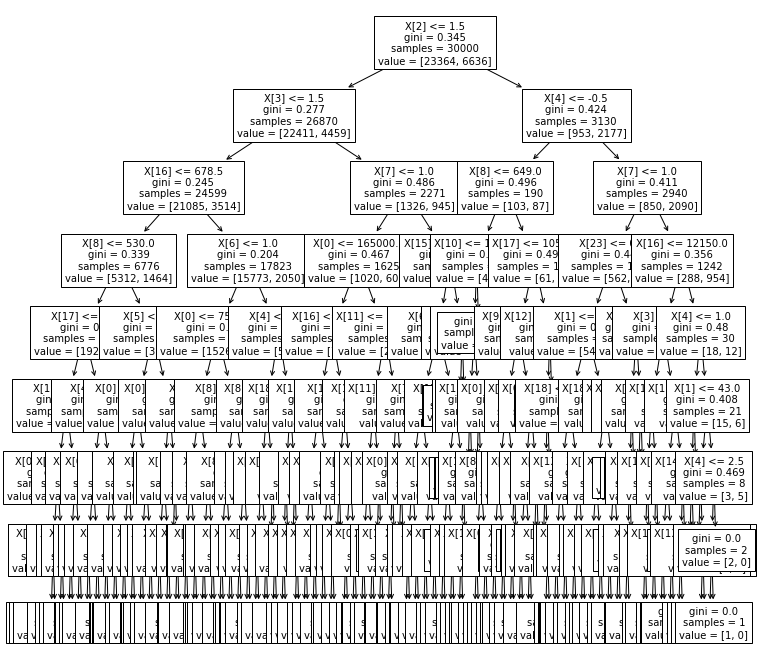

In [880]:
plt.figure(figsize = (12, 12))
tree.plot_tree(model_4, fontsize = 10)
plt.show()

In [882]:
tree.export_text(model_4)

'|--- feature_2 <= 1.50\n|   |--- feature_3 <= 1.50\n|   |   |--- feature_16 <= 678.50\n|   |   |   |--- feature_8 <= 530.00\n|   |   |   |   |--- feature_17 <= 3.50\n|   |   |   |   |   |--- feature_1 <= 55.50\n|   |   |   |   |   |   |--- feature_0 <= 25000.00\n|   |   |   |   |   |   |   |--- feature_21 <= 0.50\n|   |   |   |   |   |   |   |   |--- class: 0\n|   |   |   |   |   |   |   |--- feature_21 >  0.50\n|   |   |   |   |   |   |   |   |--- class: 1\n|   |   |   |   |   |   |--- feature_0 >  25000.00\n|   |   |   |   |   |   |   |--- feature_0 <= 315000.00\n|   |   |   |   |   |   |   |   |--- class: 0\n|   |   |   |   |   |   |   |--- feature_0 >  315000.00\n|   |   |   |   |   |   |   |   |--- class: 0\n|   |   |   |   |   |--- feature_1 >  55.50\n|   |   |   |   |   |   |--- feature_15 <= 189.00\n|   |   |   |   |   |   |   |--- feature_21 <= 0.50\n|   |   |   |   |   |   |   |   |--- class: 1\n|   |   |   |   |   |   |   |--- feature_21 >  0.50\n|   |   |   |   |   |   |  

Text(0, 0.5, 'Feature Importance Score')

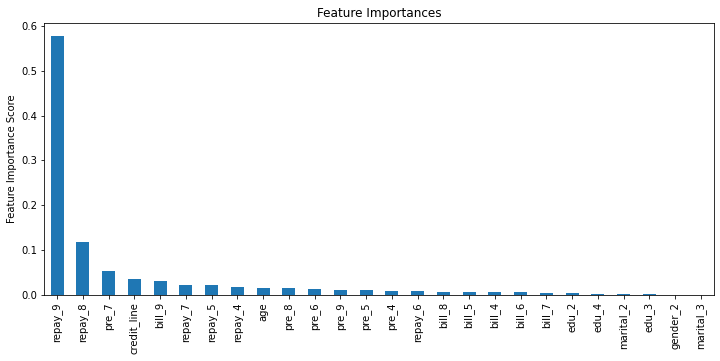

In [894]:
plt.figure(figsize = (12, 5))
feat_imp = pd.Series(model_4.feature_importances_, x_tree.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title = 'Feature Importances')
plt.ylabel('Feature Importance Score')

#### Gradient Boosting

In [633]:
# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10, 100, 250]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]

# define grid search
grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, subsample = subsample, max_depth = max_depth)

grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = folds, scoring = 'f1', error_score = 0)
grid_result = grid_search.fit(x_tree, y_tree)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.478298 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_

In [890]:
model_5 = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, 
                                     subsample = 0.5, max_depth = 3).fit(x_tree, y_tree)

scores_5 = cross_val_score(model_5, x_tree, y_tree, scoring = 'f1', cv = folds)

scores_5

array([0.4702439 , 0.48144624, 0.45819236, 0.48399612, 0.49653808])

Text(0, 0.5, 'Feature Importance Score')

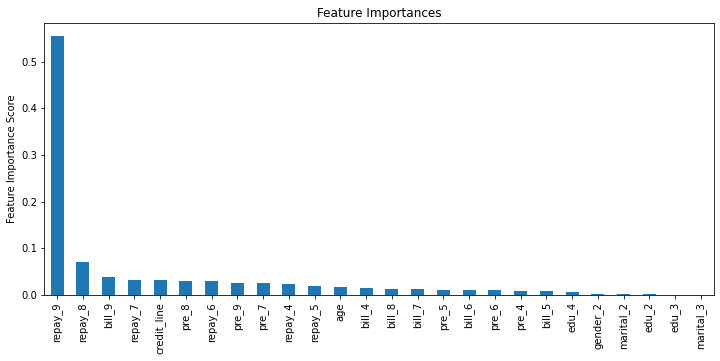

In [895]:
plt.figure(figsize = (12, 5))
feat_imp = pd.Series(model_5.feature_importances_, x_tree.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Metrics

In [925]:
model_1.predict()

array([0.54952974, 0.11301557, 0.21954917, ..., 0.84920653, 0.39453501,
       0.24622912])

In [923]:
model_2.predict()

array([0.20427444, 0.30613236, 0.25148006, ..., 0.47135407, 0.23037046,
       0.27371209])

In [912]:
model_3.predict_proba(x)

array([[0.45058913, 0.54941087],
       [0.88697761, 0.11302239],
       [0.78048172, 0.21951828],
       ...,
       [0.15091174, 0.84908826],
       [0.60555784, 0.39444216],
       [0.75382002, 0.24617998]])

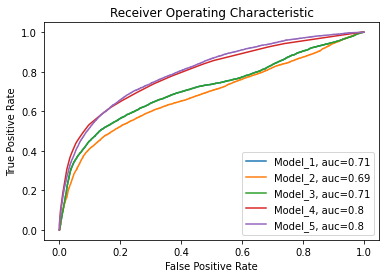

In [1004]:
y_pred_proba_1 = model_1.predict()
fpr_1, tpr_1, _ = metrics.roc_curve(y, y_pred_proba_1)
auc_1 = round(metrics.roc_auc_score(y, y_pred_proba_1), 2)

y_pred_proba_2 = model_2.predict()
fpr_2, tpr_2, _ = metrics.roc_curve(y, y_pred_proba_2)
auc_2 = round(metrics.roc_auc_score(y, y_pred_proba_2), 2)

y_pred_proba_3 = model_3.predict_proba(x)[::, 1]
fpr_3, tpr_3, _ = metrics.roc_curve(y, y_pred_proba_3)
auc_3 = round(metrics.roc_auc_score(y, y_pred_proba_3), 2)

y_pred_proba_4 = model_4.predict_proba(x_tree)[::, 1]
fpr_4, tpr_4, _ = metrics.roc_curve(y_tree, y_pred_proba_4)
auc_4 = round(metrics.roc_auc_score(y_tree, y_pred_proba_4), 2)

y_pred_proba_5 = model_5.predict_proba(x_tree)[::, 1]
fpr_5, tpr_5, _ = metrics.roc_curve(y_tree, y_pred_proba_5)
auc_5 = round(metrics.roc_auc_score(y_tree, y_pred_proba_5), 2)

plt.plot(fpr_1, tpr_1, label = "Model_1, auc="+str(auc_1))
plt.plot(fpr_2, tpr_2, label = "Model_2, auc="+str(auc_2))
plt.plot(fpr_3, tpr_3, label = "Model_3, auc="+str(auc_3))
plt.plot(fpr_4, tpr_4, label = "Model_4, auc="+str(auc_4))
plt.plot(fpr_5, tpr_5, label = "Model_5, auc="+str(auc_5))

plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 4)
plt.show()

In [956]:
model_metrics = pd.DataFrame()
col = ['models', 'Cross Validation F1', 'Accuracy', 'AUC']

In [1011]:
models = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5']
cvf1 = [round(scores_1.mean(), 2), round(scores_2.mean(), 2), 
        round(scores_3.mean(), 2), round(scores_4.mean(), 2), round(scores_5.mean(), 2)]
accuracy = [round(metrics.accuracy_score(y, list(map(round, model_1.predict()))), 2), 
            round(metrics.accuracy_score(y, list(map(round, model_2.predict()))), 2), 
            round(model_3.score(x, y), 2), 
            round(model_4.score(x_tree, y_tree), 2), 
            round(model_5.score(x_tree, y_tree), 2)]
auc = [auc_1, auc_2, auc_3, auc_4, auc_5]

dict_metrics = {'models' : models, 'cross validation f1 score' : cvf1, 
                'accuracy' : accuracy, 'auc' : auc}

pd.DataFrame(dict_metrics)

,models,cross validation f1 score,accuracy,auc
0,model_1,0.37,0.81,0.71
1,model_2,0.24,0.80,0.69
2,model_3,0.37,0.81,0.71
3,model_4,0.48,0.83,0.80
4,model_5,0.48,0.83,0.80
